In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Any
import sys
import copy
import matplotlib.pyplot as plt

from src.dataclass import (
    Input, Lattice, Parameter, Train, Save,
    Processed_Input, Topology, Conjugate, Result
)
from src.manage_data import save_result, save_log, load_result

In [2]:
df = load_result()
df.columns.values

array(['key', 'state', 'size', 'dimension', 'ghost', 'initial', 'T', 'H',
       'Tc', 'Hc', 'Jm', 'Jv', 'mode', 'variable', 'multiply', 'base',
       'exponent', 'iteration', 'sweep', 'measurement', 'interval',
       'ensemble', 'max_workers', 'threshold', 'recent', 'environment',
       'save', 'order_parameter', 'susceptibility', 'binder_cumulant',
       'spin_glass_order', 'spin_glass_suscept', 'spin_glass_binder',
       'energy', 'specific_heat', 'irreducible_distance',
       'correlation_function', 'autocorrelation', 'time'], dtype=object)

In [3]:
state, size, dimension, Jv = (
    3,
    64,
    2,
    0.0,
)

yt, yh = (6/5, 28/15)

alpha, beta, gamma, delta, nu, eta = (
    2-dimension/yt,
    (dimension-yh)/yt,
    (2*yh-dimension)/yt,
    yh/(dimension-yh),
    1/yt,
    dimension-2*yh+2,
)

filter_ = (df["state"] == state) & (df["size"] == size) & (df["dimension"] == dimension) & (df["Jv"] == Jv)
data = df[filter_].sort_values(by=['T'], ascending=[True])
print(np.size(data["irreducible_distance"]))

45


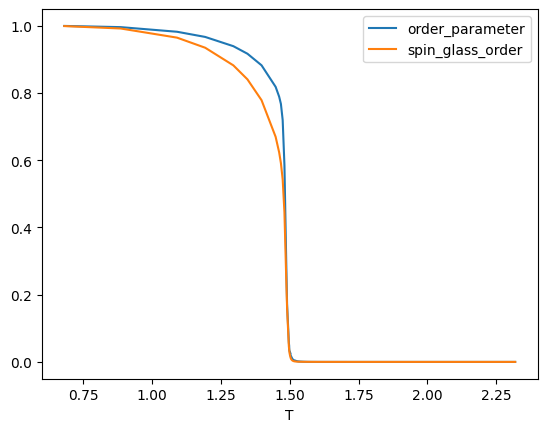

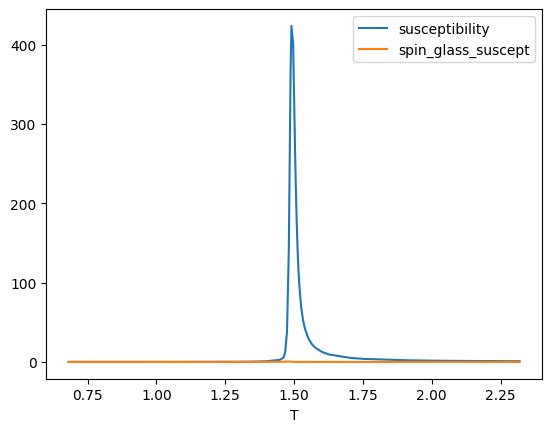

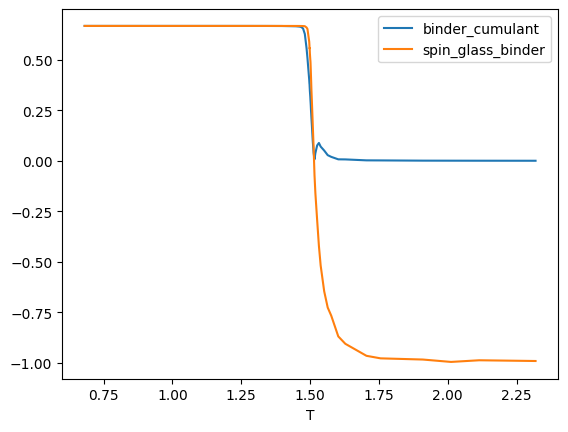

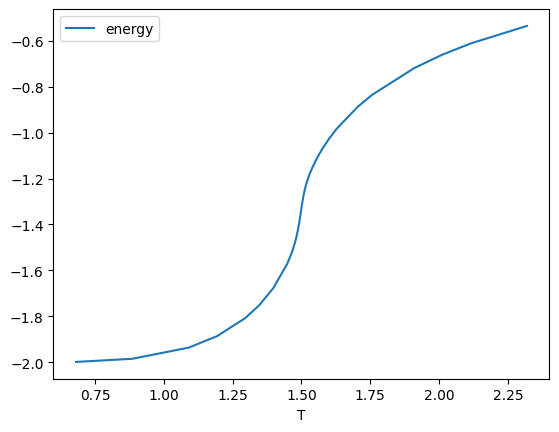

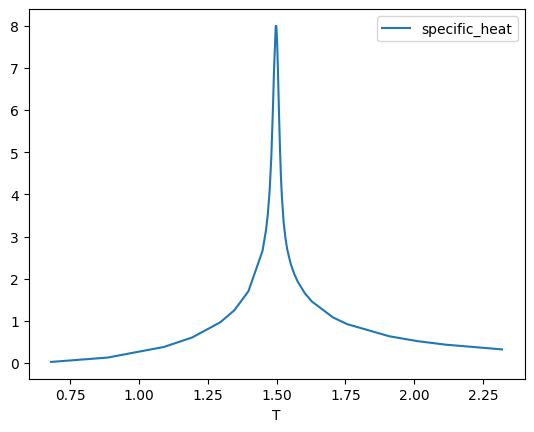

In [4]:
data.plot(kind="line", x="T", y=["order_parameter", "spin_glass_order"])
data.plot(kind="line", x="T", y=["susceptibility", "spin_glass_suscept"])
data.plot(kind="line", x="T", y=["binder_cumulant", "spin_glass_binder"])
data.plot(kind="line", x="T", y=["energy"])
data.plot(kind="line", x="T", y=["specific_heat"])
# data[data["T"]==1.5001].plot(kind="line", x="irreducible_distance", y=["correlation_function"])
plt.show()

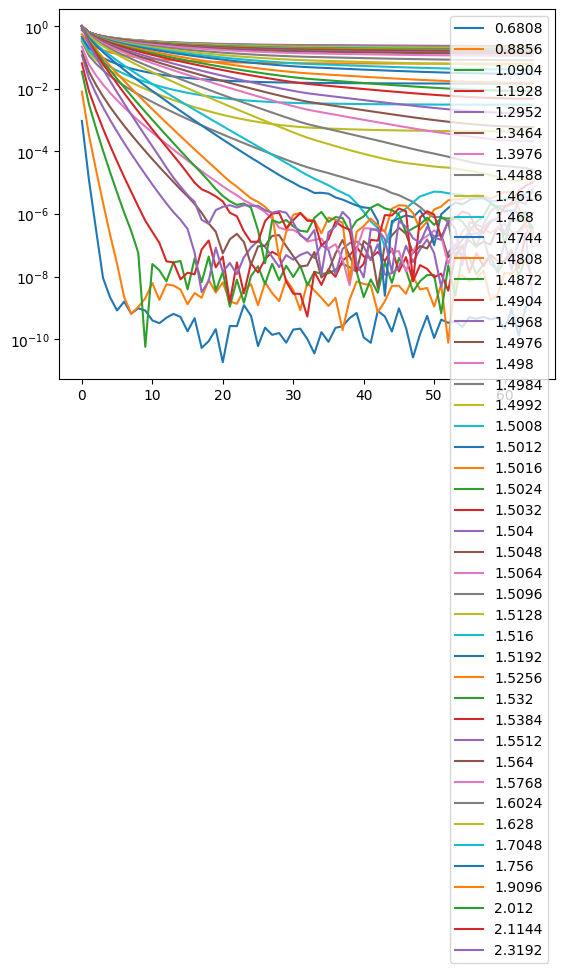

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)

# ax[0,0].plot()
for i, irr_dist in enumerate(np.array(data["irreducible_distance"])):
    ax.plot(irr_dist, np.array(data["correlation_function"])[i], label=np.round(np.array(data["T"])[i],4))

ax.set_yscale("log")
plt.legend()

plt.show()


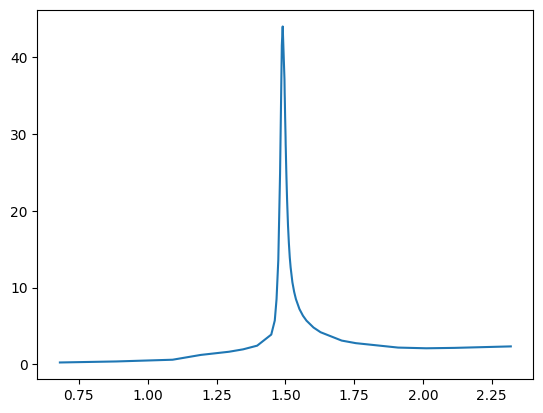

In [6]:
from sklearn.linear_model import LinearRegression

x_min, x_max = (0, size/max(16/np.sqrt(size),2))
y_min = 10**-7

correlation_length = []

for i, distance_list in enumerate(np.array(data["irreducible_distance"])):
    correlation = np.array(data["correlation_function"])[i]
    x, y = [], []
    for j, distance in enumerate(distance_list):
        if(x_min <= distance <= x_max and correlation[j] >= y_min):
            x.append(distance)
            y.append(np.log(correlation[j]))
    
    x, y = np.array(x).reshape((-1, 1)), np.array(y)
    
    # print(x, y)
    model = LinearRegression().fit(x, y)
    correlation_length.append(-1/model.coef_)

fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(data["T"], correlation_length)

plt.show()

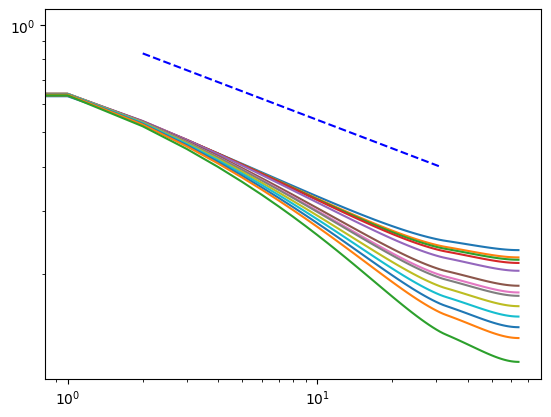

In [7]:
T_min = 1.492
T_max = 2 * 1.5 - T_min

filter_ = (T_min<=data["T"]) & (data["T"]<=T_max)
corr = data[filter_]

fig, ax = plt.subplots(nrows=1, ncols=1)

# ax[0,0].plot()
for i, irr_dist in enumerate(np.array(corr["irreducible_distance"])):
    ax.plot(irr_dist, np.array(corr["correlation_function"])[i])

def g(x):
    return 1/x**(dimension-2+eta)

x = np.arange(2,size/2)
ax.plot(x,g(x),"--",color="b")

ax.loglog()

plt.show()

In [8]:
x_min, x_max = (1, size/max(16/np.sqrt(size),8))

measure_eta = []

for i, distance_list in enumerate(np.array(corr["irreducible_distance"])):
    correlation = np.array(corr["correlation_function"])[i]
    x, y = [], []
    for j, distance in enumerate(distance_list):
        if(x_min <= distance <= x_max):
            x.append(np.log(distance))
            y.append(np.log(correlation[j]))
    
    x, y = np.array(x).reshape((-1, 1)), np.array(y)
    
    # print(x, y)
    model = LinearRegression().fit(x, y)
    measure_eta.append(2-dimension-model.coef_)

measure_eta = np.average(measure_eta)

print(f"measure eta = {measure_eta}")
print(f"real eta: {eta}")

measure eta = 0.32340185653130604
real eta: 0.2666666666666666
